train120m-180m, train:valid 75:25, delete os-device

In [1]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc
from contextlib import contextmanager
import pickle
import matplotlib.pyplot as plt

In [2]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
def df_add_counts(df, cols):
    arr_slice = df[cols].values
    unq, unqtags, counts = np.unique(np.ravel_multi_index(arr_slice.T, arr_slice.max(axis=0) + 1),
                                     return_inverse=True, return_counts=True)
    df["_".join(cols)+'_count'] = counts[unqtags]
    
def make_count_features(df):
    with timer("add count features"):
        df['click_time']= pd.to_datetime(df['click_time'])
        dt= df['click_time'].dt
        df['day'] = dt.day.astype('uint8')
        df['hour'] = dt.hour.astype('uint8')
#         df['minute'] = dt.minute.astype('uint8')
#         df['second'] = dt.second.astype('uint8')#secondを追加

        del(dt)
        
        df_add_counts(df, ['ip'])
#         df_add_counts(df, ['ip','day','hour','minute'])
#         df_add_counts(df, ['os','device'])
        df_add_counts(df, ['os','app','channel'])
        
        df_add_counts(df, ['ip', 'day', 'hour'])
        df_add_counts(df, ['ip', 'app'])
        df_add_counts(df, ['ip', 'app', 'os'])
        df_add_counts(df, ['ip', 'device'])
        df_add_counts(df, ['app', 'channel'])

def make_next_click_feature(df):
    with timer("Adding next click times"):
        D= 2**26
        df['category'] = (df['ip'].astype(str) + "_" + df['app'].astype(str) + "_" + df['device'].astype(str) \
                         + "_" + df['os'].astype(str)).apply(hash) % D
        click_buffer= np.full(D, 3000000000, dtype=np.uint32)
        df['epochtime']= df['click_time'].astype(np.int64) // 10 ** 9
        next_clicks= []
        for category, time in zip(reversed(df['category'].values), reversed(df['epochtime'].values)):
            next_clicks.append(click_buffer[category]-time)
            click_buffer[category]= time
        del(click_buffer)
        df['next_click']= list(reversed(next_clicks))
        
path = '~/talkingdata/input/'

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

columns = ['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

In [3]:
with timer("load training data"):
    train_df = pd.read_csv(path+"train.csv",skiprows=range(1,122071518), usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'], dtype=dtypes)

with timer("load test data"):
    testsup_df = pd.read_csv(path+"test_supplement.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

[load training data] done in 139 s
[load test data] done in 49 s


In [4]:
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed
0,62766,7,3543,748,101,2017-11-08 16:00:00,0
1,108229,15,1,19,245,2017-11-08 16:00:00,0
2,73487,12,2,22,326,2017-11-08 16:00:00,0
3,238206,14,1,19,379,2017-11-08 16:00:00,0
4,27482,26,1,32,121,2017-11-08 16:00:00,0


In [5]:
train_df.tail()

,ip,app,device,os,channel,click_time,is_attributed
62832368,121312,12,1,10,340,2017-11-09 16:00:00,0
62832369,46894,3,1,19,211,2017-11-09 16:00:00,0
62832370,320126,1,1,13,274,2017-11-09 16:00:00,0
62832371,189286,12,1,37,259,2017-11-09 16:00:00,0
62832372,106485,11,1,19,137,2017-11-09 16:00:00,0


In [ ]:
num_train = train_df.shape[0]

y = train_df.is_attributed.values
gc.collect()

# sub = pd.DataFrame()
# sub['click_id'] = test_df.click_id.values

common_column = ['ip','app','device','os','channel','click_time']
concat_df = pd.concat([train_df[common_column],testsup_df[common_column]])

del train_df, testsup_df
gc.collect()

58

In [13]:
make_count_features(concat_df)
make_next_click_feature(concat_df)

gc.collect()

NameError: name 'concat_df' is not defined

In [ ]:
train_df = concat_df.iloc[:num_train]
testsup_df = concat_df.iloc[num_train:]

del concat_df
gc.collect()

# with open('train_after.csv.pkl','wb') as f:
#   pickle.dump(train_df, f, protocol=2)

# with open('valid_after.csv.pkl','wb') as f:
#   pickle.dump(val_df, f, protocol=2)

# with open('test_after.csv.pkl','wb') as f:
#   pickle.dump(test_df, f, protocol=2)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(train_df, y, train_size=0.75, shuffle=False)
evals_results = {}
num_boost_round = 250
early_stopping_rounds = 30

/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [19]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': 12,
    'verbose': 0,
    'metric':'auc',     
 
    'learning_rate': 0.15,
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':99
}
# metrics = 'auc'
# lgb_params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': metrics,
#     'learning_rate': .1,
#     'num_leaves': 7,
#     'max_depth': 4,
#     'min_child_samples': 100,
#     'max_bin': 100,
#     'subsample': 0.7,
#     'subsample_freq': 1,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 0,
#     'min_split_gain': 0,
#     'nthread': 4,
#     'verbose': 1,
#     'scale_pos_weight': 99.7
#     #'scale_pos_weight': 400
# }

In [20]:
target = "is_attributed"
categorical = ['app','os','channel','device','hour']
predictors = list(set(train_df.columns)-set([target])-set(['click_time','category','epochtime','day','ip']))
print(predictors)

print("preparing validation datasets")

xgtrain = lgb.Dataset(x_train[predictors].values,
                      label=y_train,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

del x_train
del y_train
gc.collect()

xgvalid = lgb.Dataset(x_val[predictors].values,
                      label=y_val,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

del x_val
del y_val
gc.collect()

['ip_app_os_count', 'ip_count', 'ip_day_hour_count', 'ip_device_count', 'app_channel_count', 'hour', 'next_click', 'os_app_channel_count', 'app', 'channel', 'device', 'ip_app_count', 'os']
preparing validation datasets


15

In [21]:
# gc.collect()
booster = lgb.train(
     lgb_params, 
     xgtrain,
     valid_sets=[xgvalid],
     valid_names=['valid'],
     evals_result=evals_results, 
     num_boost_round=num_boost_round,
     early_stopping_rounds=early_stopping_rounds,
     verbose_eval=1
)

del xgvalid
del xgtrain
gc.collect()

/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid's auc: 0.95168
Training until validation scores don't improve for 30 rounds.
[2]	valid's auc: 0.952738
[3]	valid's auc: 0.957304
[4]	valid's auc: 0.958839
[5]	valid's auc: 0.964307
[6]	valid's auc: 0.965751
[7]	valid's auc: 0.966046
[8]	valid's auc: 0.96603
[9]	valid's auc: 0.966028
[10]	valid's auc: 0.966672
[11]	valid's auc: 0.966607
[12]	valid's auc: 0.967239
[13]	valid's auc: 0.967918
[14]	valid's auc: 0.968766
[15]	valid's auc: 0.96894
[16]	valid's auc: 0.969211
[17]	valid's auc: 0.969469
[18]	valid's auc: 0.969784
[19]	valid's auc: 0.970494
[20]	valid's auc: 0.970624
[21]	valid's auc: 0.971655
[22]	valid's auc: 0.972504
[23]	valid's auc: 0.97251
[24]	valid's auc: 0.97274
[25]	valid's auc: 0.973397
[26]	valid's auc: 0.973889
[27]	valid's auc: 0.974403
[28]	valid's auc: 0.974785
[29]	valid's auc: 0.975257
[30]	valid's auc: 0.975647
[31]	valid's auc: 0.976095
[32]	valid's auc: 0.976744
[33]	valid's auc: 0.977082
[34]	valid's auc: 0.977356
[35]	valid's auc: 0.977667
[36]	va

32

In [24]:
n_estimators = booster.best_iteration
metrics = 'auc'

print('\nModel Info:')
print('n_estimators:', n_estimators)
print(metrics+':', evals_results['valid'][metrics][n_estimators-1])


Model Info:
n_estimators: 92
auc: 0.9817349697868897


In [26]:
evals_results

{'valid': defaultdict(list,
             {'auc': [0.9516797772709538,
               0.9527383430464113,
               0.9573039349240963,
               0.9588387633802782,
               0.9643070939228539,
               0.9657513593796656,
               0.966046285393099,
               0.9660300419319414,
               0.9660276427913876,
               0.9666722318838047,
               0.9666065884525565,
               0.9672387151585627,
               0.9679175082043602,
               0.9687658414104768,
               0.9689399796959989,
               0.9692109472581657,
               0.9694694792966306,
               0.9697839460321767,
               0.9704935252663397,
               0.9706240835335626,
               0.9716551861094856,
               0.9725041463909974,
               0.9725098292892321,
               0.972739775860645,
               0.9733965609767549,
               0.9738892472773062,
               0.9744025048904745,
               0.97478

In [25]:
xgtrain = lgb.Dataset(train_df[predictors].values,
                      label=y,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

del train_df
del y
gc.collect()

200

In [27]:
#validででたbooster.best_iterationで学習を止めるべきなのか？
model = lgb.train(
     lgb_params, 
     xgtrain,
     valid_sets=[xgtrain],
     valid_names=['train'],
     evals_result=evals_results, 
     num_boost_round=num_boost_round,
     early_stopping_rounds=early_stopping_rounds,
     verbose_eval=1
)

del xgtrain
gc.collect()

/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/um003580/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	train's auc: 0.941516
Training until validation scores don't improve for 30 rounds.
[2]	train's auc: 0.942982
[3]	train's auc: 0.950202
[4]	train's auc: 0.950458
[5]	train's auc: 0.962866
[6]	train's auc: 0.963278
[7]	train's auc: 0.964005
[8]	train's auc: 0.964033
[9]	train's auc: 0.96413
[10]	train's auc: 0.964809
[11]	train's auc: 0.965586
[12]	train's auc: 0.966167
[13]	train's auc: 0.966476
[14]	train's auc: 0.966571
[15]	train's auc: 0.968807
[16]	train's auc: 0.969015
[17]	train's auc: 0.969198
[18]	train's auc: 0.969307
[19]	train's auc: 0.969963
[20]	train's auc: 0.970338
[21]	train's auc: 0.97117
[22]	train's auc: 0.971542
[23]	train's auc: 0.971876
[24]	train's auc: 0.972127
[25]	train's auc: 0.972672
[26]	train's auc: 0.973498
[27]	train's auc: 0.97405
[28]	train's auc: 0.974297
[29]	train's auc: 0.974818
[30]	train's auc: 0.97504
[31]	train's auc: 0.975222
[32]	train's auc: 0.975728
[33]	train's auc: 0.975895
[34]	train's auc: 0.976103
[35]	train's auc: 0.97636
[36]	tr

32

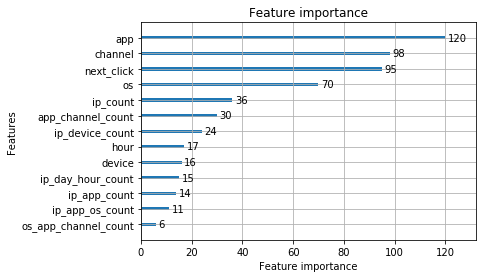

In [29]:
ax = lgb.plot_importance(booster, max_num_features=100)
plt.show()

In [ ]:
plt.savefig('0502-2imp.png', dpi=600, bbox_inches='tight')

In [44]:
gc.collect()

174

In [64]:
testsup_df.head()

,ip,app,device,os,channel,click_time,day,hour,ip_count,os_app_channel_count,ip_day_hour_count,ip_app_count,ip_app_os_count,ip_device_count,app_channel_count,category,epochtime,next_click,is_attributed
0,43570,3,1,18,379,2017-11-09 14:23:39,9,14,1767,28770,27,230,28,1733,645352,64213756,1510237419,18443,0.049027
1,80528,3,1,13,379,2017-11-09 14:23:51,9,14,2415,137665,67,401,90,2406,645352,28651620,1510237431,5531,0.045375
2,32323,3,1,13,379,2017-11-09 14:25:57,9,14,5100,137665,154,714,138,4778,645352,64520560,1510237557,9331,0.067125
3,42887,3,1,17,379,2017-11-09 14:26:03,9,14,3353,30960,126,445,19,2763,645352,3165926,1510237563,71400,0.052929
4,119289,58,1,30,120,2017-11-09 14:26:41,9,14,131195,244,9093,532,4,113403,36675,59215531,1510237601,1489762399,0.021473


In [67]:
with timer("load test data"):
    test_df = pd.read_csv(path+"test.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

[load test data] done in 13 s


In [68]:
test_df.dtypes

click_id      uint32
ip            uint32
app           uint16
device        uint16
os            uint16
channel       uint16
click_time    object
dtype: object

In [69]:
testsup_df.dtypes

ip                       uint32
app                      uint16
device                   uint16
os                       uint16
channel                  uint16
click_time               object
day                       uint8
hour                      uint8
ip_count                  int64
os_app_channel_count      int64
ip_day_hour_count         int64
ip_app_count              int64
ip_app_os_count           int64
ip_device_count           int64
app_channel_count         int64
category                  int64
epochtime                 int64
next_click                int64
is_attributed           float64
dtype: object

In [70]:
test_df['click_time']= pd.to_datetime(test_df['click_time'])
testsup_df['click_time']= pd.to_datetime(testsup_df['click_time'])

In [53]:
# preditions=booster.predict(test_df[predictors].values)

print("Predicting the submission data...")

testsup_df['is_attributed'] = booster.predict(testsup_df[predictors], num_iteration=booster.best_iteration)

print('projecting prediction onto test')

join_cols = ['ip', 'app', 'device', 'os', 'channel', 'click_time']
all_cols = join_cols + ['is_attributed']

Predicting the submission data...
projecting prediction onto test


In [71]:
test_df = test_df.merge(testsup_df[all_cols], how='left', on=join_cols)

test_df = test_df.drop_duplicates(subset=['click_id'])

In [72]:
test_df.head()

,click_id,ip,app,device,os,channel,click_time,is_attributed
0,0,5744,9,1,3,107,2017-11-10 04:00:00,0.075813
1,1,119901,9,1,3,466,2017-11-10 04:00:00,0.020265
2,2,72287,21,1,19,128,2017-11-10 04:00:00,0.003297
3,3,78477,15,1,13,111,2017-11-10 04:00:00,0.014700
4,4,123080,12,1,13,328,2017-11-10 04:00:00,0.007028


In [73]:
test_df.count()

click_id         18790469
ip               18790469
app              18790469
device           18790469
os               18790469
channel          18790469
click_time       18790469
is_attributed    18790469
dtype: int64

In [74]:
print("Writing the submission data into a csv file...")

test_df[['click_id', 'is_attributed']].to_csv('0502-2.csv', index=False)

print("All done...")

Writing the submission data into a csv file...
All done...
